# Object segmentation on OpenCL-compatible GPUs
APOC is based on [pyclesperanto](https://github.com/clEsperanto/pyclesperanto_prototype) and [sklearn](https://scikit-learn.org/stable/). For object segmentation, it uses a pixel classifier and connected components labeling.

Let's start with loading an example image and some ground truth:

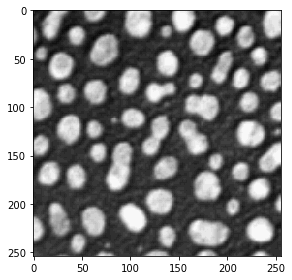

In [2]:
from skimage.io import imread, imshow
image = imread('blobs.tif')
imshow(image)

In [3]:
if False: # you can use this to make manual annotations
    import numpy as np
    import napari

    # start napari
    viewer = napari.Viewer()
    napari.run()

    # add image
    viewer.add_image(image)

    # add an empty labels layer and keep it in a variable
    labels = np.zeros(image.shape).astype(int)
    viewer.add_labels(labels)
else:
    labels = imread('annotations.tif')

C:\Users\rober\miniconda3\envs\bio2\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


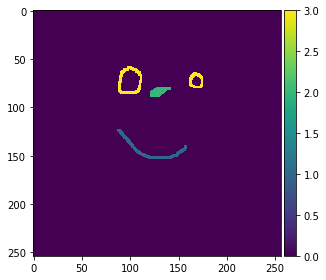

In [4]:
manual_annotations = labels

from skimage.io import imshow
imshow(manual_annotations, vmin=0, vmax=3)

## Training
We now train a ObjectSegmenter, which is under the hood a [scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). After training, the classifier will be converted to [clij-compatible OpenCL code](https://github.com/clEsperanto/clij-opencl-kernels) and save to disk under a given filename.

In [5]:
from apoc import ObjectSegmenter
import numpy as np

# define features: original image, a blurred version and an edge image
features = "original gaussian_blur=2 sobel_of_gaussian_blur=2"

# this is where the model will be saved
cl_filename = 'my_model.cl'

clf = ObjectSegmenter(opencl_filename=cl_filename, positive_class_identifier=2)
clf.train(features, manual_annotations, image)

NameError: name 'os' is not defined

## Prediction / segmentation
The classifier can then be used to classify all pixels in the given image. Starting point is again, the feature stack. Thus, the user must make sure that the same features are used for training and for prediction. Prediction can be done on the CPU using the original scikit-learn code and on the GPU using the generated OpenCL-code. OCLRFC works well if both result images look identical.

In [9]:
# to measure kernel execution duration properly, we need to set this flag. It will slow down exection of workflows a bit though
import pyclesperanto_prototype as cle
cle.set_wait_for_kernel_finish(True)
# print out which GPU is used
cle.get_device()

<gfx90c on Platform: AMD Accelerated Parallel Processing (22 refs)>

To measure prediction time without feature stack generation time, we prepare a feature stack in advance:

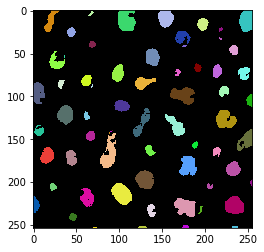

In [12]:
result = clf.predict(features, image)
cle.imshow(result, labels=True)

# Segmentation from a loaded segmenter

In [1]:
clf = ObjectSegmenter(opencl_filename=cl_filename)

result = clf.predict(image = image)
cle.imshow(result, labels=True)

NameError: name 'ObjectSegmenter' is not defined